#### Parameters

⚠️ Notice: change the corresponding parameters in the constructor of 'DistilHuBERTClassifier' of train.py to match the testing model.

In [ ]:
model_path = "models/SemanticVAD_2.pt" 
csv_path = "dataset/collected_dataset.csv"
batch_size = 1
test_mode = 1
test_size = 1000
num_classes = 2

MODEL_NAME = "distilbert-base-uncased"
NUM_LABELS = 2

#### Dataset Class

In [2]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torch
from transformers import DistilBertTokenizerFast
from transformers.modeling_outputs import SequenceClassifierOutput

class CSVTestDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=128):
        df = pd.read_csv(csv_file)
        self.texts = df["text"].tolist()
        self.labels = df["labels"]
        self.encodings = tokenizer(self.texts, truncation=True, padding="max_length", max_length=max_length)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encodings["input_ids"][idx])
        attention_mask = torch.tensor(self.encodings["attention_mask"][idx])
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return input_ids, attention_mask, label

#### Load Models

In [ ]:
from torch import nn

class DistilBERTBackchannelScorer(nn.Module):
    def __init__(self, hidden_dim=768):
        super().__init__()
        self.encoder = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]  # CLS token
        logits = self.classifier(pooled).squeeze(-1)  # shape: (batch_size,)
        loss = None
        if labels is not None:
            labels = labels.float()
            loss = nn.BCEWithLogitsLoss()(logits, labels)
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from transformers import DistilBertTokenizerFast, DistilBertModel
# load tokenizer & model
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = DistilBERTBackchannelScorer()
model.load_state_dict(torch.load(model_path))
model.eval()

DistilBERTBackchannelScorer(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
           

#### Test

In [5]:
def collate_fn(batch):
    input_ids = torch.stack([item[0] for item in batch])
    attention_mask = torch.stack([item[1] for item in batch])
    labels = torch.stack([item[2] for item in batch])
    return input_ids, attention_mask, labels

test_dataset = CSVTestDataset(csv_path, tokenizer)

# Construct DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn)

In [8]:
# Test
all_preds = []
all_labels = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        input_ids, attention_mask, labels = batch

        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits.squeeze()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        if preds.dim() == 0:
            # batch size = 1
            all_preds.append(preds.cpu().item())
            all_labels.append(labels.cpu().item())
            labels = labels.view(-1)
            probs = probs.view(-1)
            preds = preds.view(-1)

            for idx in range(len(labels)):
                print(f"Sample {i * len(labels) + idx} | True: {int(labels[idx].item())} | Pred: {int(preds[idx].item())} | Prob: {probs[idx]:.4f}")
        else:
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            for idx in range(len(labels)):
                print(f"Sample {i * 8 + idx} | True: {int(labels[idx].item())} | Pred: {int(preds[idx].item())} | Prob: {probs[idx]:.4f}")


# show result
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

overall_accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Overall Accuracy: {overall_accuracy*100:.2f}%")

f1 = f1_score(all_labels, all_preds)
print(f"✅ F1 Score: {f1:.4f}")

for cls in [0, 1]:
    cls_idx = (all_labels == cls)
    if cls_idx.sum() == 0:
        print(f"⚠️ Class {cls} has no samples.")
        continue
    cls_acc = (all_preds[cls_idx] == all_labels[cls_idx]).sum() / cls_idx.sum()
    print(f"🎯 Class {cls} Accuracy: {cls_acc*100:.2f}%")

Sample 0 | True: 1 | Pred: 1 | Prob: 0.9929
Sample 1 | True: 1 | Pred: 1 | Prob: 0.9929
Sample 2 | True: 0 | Pred: 0 | Prob: 0.0123
Sample 3 | True: 1 | Pred: 1 | Prob: 0.9929
Sample 4 | True: 0 | Pred: 0 | Prob: 0.0119
Sample 5 | True: 1 | Pred: 1 | Prob: 0.9931
Sample 6 | True: 0 | Pred: 0 | Prob: 0.0256
Sample 7 | True: 1 | Pred: 1 | Prob: 0.9929
Sample 8 | True: 0 | Pred: 0 | Prob: 0.0119
Sample 9 | True: 1 | Pred: 1 | Prob: 0.9930
Sample 10 | True: 0 | Pred: 1 | Prob: 0.9629
Sample 11 | True: 0 | Pred: 0 | Prob: 0.0137
Sample 12 | True: 1 | Pred: 1 | Prob: 0.9931
Sample 13 | True: 0 | Pred: 0 | Prob: 0.0120
Sample 14 | True: 0 | Pred: 0 | Prob: 0.0116
Sample 15 | True: 0 | Pred: 0 | Prob: 0.0118
Sample 16 | True: 1 | Pred: 1 | Prob: 0.9930
Sample 17 | True: 1 | Pred: 1 | Prob: 0.9931
Sample 18 | True: 0 | Pred: 1 | Prob: 0.9932
Sample 19 | True: 1 | Pred: 1 | Prob: 0.9931
Sample 20 | True: 0 | Pred: 0 | Prob: 0.0117
Sample 21 | True: 1 | Pred: 1 | Prob: 0.9908
Sample 22 | True: 0 

Matrix

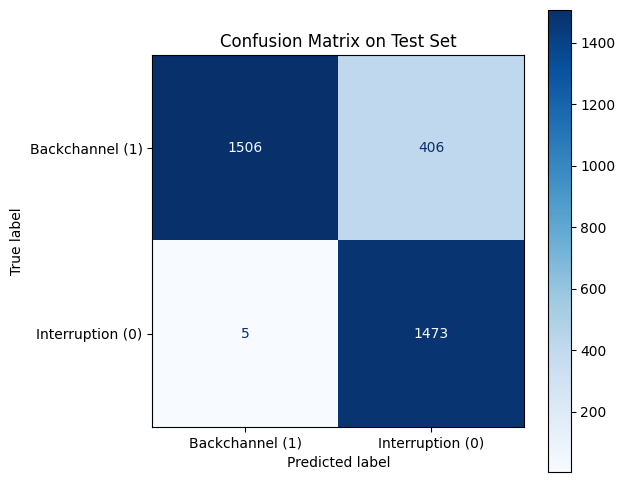

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

num_classes = len(np.unique(all_labels))
cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))

# labels
display_labels = ["Backchannel (1)", "Interruption (0)"]

# plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, colorbar=True, values_format='d')  # values_format='d'
plt.title("Confusion Matrix on Test Set")
plt.show()